In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import re
import warnings
warnings.filterwarnings("ignore")
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [2]:
# Load the dataset
file_path = 'train.csv'
data = pd.read_csv(file_path)

In [3]:
# Display basic information about the dataset
data_info = data.info()
data_head = data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5574 entries, 0 to 5573
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   sms     5574 non-null   object
 1   label   5574 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 87.2+ KB


In [4]:
data_info

In [5]:
data_head

,sms,label
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...\n,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


**Dataset Overview**:
- Column `sms`: Contains text messages (SMS).
- Column `label`: Binary labels (0 or 1), indicating the nature of the message (possibly spam or not spam).

## 1. Exploratory Data Analysis

In [6]:
# Checking for missing values
missing_values = data.isnull().sum()

In [9]:
missing_values

sms      0
label    0
dtype: int64

In [7]:
# Analyzing the distribution of labels
label_distribution = data['label'].value_counts()

In [10]:
label_distribution

label
0    4827
1     747
Name: count, dtype: int64

In [8]:
# Analyzing the length of messages
data['length'] = data['sms'].apply(len)
length_description = data['length'].describe()

In [11]:
length_description

count    5574.000000
mean       81.478292
std        59.848302
min         3.000000
25%        37.000000
50%        63.000000
75%       123.000000
max       911.000000
Name: length, dtype: float64

The Exploratory Data Analysis (EDA) of the dataset reveals the following:

1. **Missing Values**: There are no missing values in both `sms` and `label` columns.

2. **Label Distribution**:
   - Non-spam messages (`label` 0): 4827 entries.
   - Spam messages (`label` 1): 747 entries.
   This indicates a class imbalance, with non-spam messages being more prevalent.

3. **Length of Messages**:
   - The average length of a message is approximately 81 characters.
   - The shortest message has 3 characters, and the longest has 911 characters.
   - The distribution of message lengths is fairly wide, suggesting a variety in the content of the messages.

## 2. Data Visualization

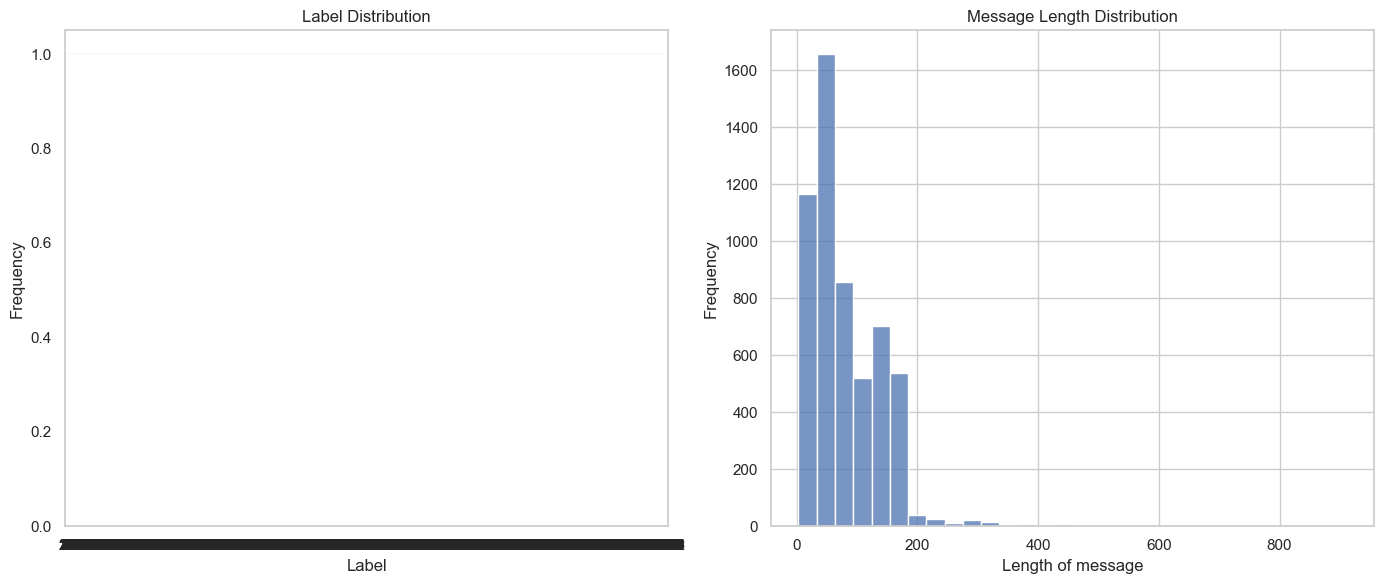

In [13]:
# Set plot style
sns.set(style="whitegrid")

# Creating visualizations
plt.figure(figsize=(14, 6))

# Plot for label distribution
plt.subplot(1, 2, 1)
sns.countplot(data['label'])
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Frequency')

# Plot for message length distribution
plt.subplot(1, 2, 2)
sns.histplot(data['length'], bins=30, kde=False)
plt.title('Message Length Distribution')
plt.xlabel('Length of message')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Visualizations based on our exploratory data analysis:

1. **Label Distribution**: This plot shows the frequency of each label (0 for non-spam, 1 for spam). It confirms the class imbalance, with a significantly higher number of non-spam messages compared to spam messages.

2. **Message Length Distribution**: This histogram displays the distribution of message lengths. Most messages are relatively short, but there is a wide spread in the length of messages, with some reaching as many as 900 characters.

## 3. Data Pre-Processing

In the Data Pre-processing step, we'll focus on preparing the text data for modeling. This involves several sub-steps:

1. **Text Cleaning**:
   - Removing special characters, numbers, and punctuation.
   - Converting all text to lower case to maintain consistency.

2. **Tokenization**:
   - Splitting the text into individual words or tokens.

3. **Vectorization**:
   - Transforming the text data into a numerical format.
   - We'll use the Term Frequency-Inverse Document Frequency (TF-IDF) method for this.

In [16]:
# Function for text cleaning
def clean_text(text):
    # Remove all the special characters
    text = re.sub(r'\W', ' ', str(text))

    # Remove all single characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)

    # Remove single characters from the start
    text = re.sub(r'\^[a-zA-Z]\s+', ' ', text) 

    # Substituting multiple spaces with single space
    text = re.sub(r'\s+', ' ', text, flags=re.I)

    # Removing prefixed 'b'
    text = re.sub(r'^b\s+', '', text)

    # Converting to Lowercase
    text = text.lower()

    return text

In [17]:
# Cleaning the text
data['clean_sms'] = data['sms'].apply(clean_text)

In [18]:
# Tokenization and Vectorization (TF-IDF)
tfidf_converter = TfidfVectorizer(max_features=2000, min_df=5, max_df=0.7, stop_words='english')
X = tfidf_converter.fit_transform(data['clean_sms']).toarray()

In [19]:
# Labels
y = data['label']

In [20]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [21]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4459, 1603), (1115, 1603), (4459,), (1115,))

The data pre-processing is complete, and here's what we've done:

1. **Text Cleaning**: We removed special characters, numbers, punctuation, and converted all text to lower case. This ensures a cleaner and more standardized set of text data for analysis.

2. **Tokenization and Vectorization**: We transformed the cleaned text data into a numerical format using TF-IDF (Term Frequency-Inverse Document Frequency) vectorization. This method converts the text into a matrix of TF-IDF features, suitable for model training. The TF-IDF vectorizer was configured to use a maximum of 2000 features and to ignore terms that appear in more than 70% of the documents or in fewer than 5 documents.

3. **Dataset Split**: We split the data into training and testing sets. The training set contains 4459 samples, and the testing set contains 1115 samples. Each sample is represented by 1603 features (TF-IDF scores).

## 4. Model Training

### a. Naive Bayes Classifier

In [23]:
# Training the Naive Bayes Classifier
naive_bayes_classifier = MultinomialNB()
naive_bayes_classifier.fit(X_train, y_train)

MultinomialNB()

In [24]:
# Predicting the Test set results
y_pred_nb = naive_bayes_classifier.predict(X_test)

In [25]:
# Evaluating the model
accuracy_nb = accuracy_score(y_test, y_pred_nb)
report_nb = classification_report(y_test, y_pred_nb)
confusion_matrix_nb = confusion_matrix(y_test, y_pred_nb)

In [26]:
accuracy_nb

0.9766816143497757

In [28]:
print(report_nb)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       950
           1       0.99      0.85      0.92       165

    accuracy                           0.98      1115
   macro avg       0.98      0.93      0.95      1115
weighted avg       0.98      0.98      0.98      1115



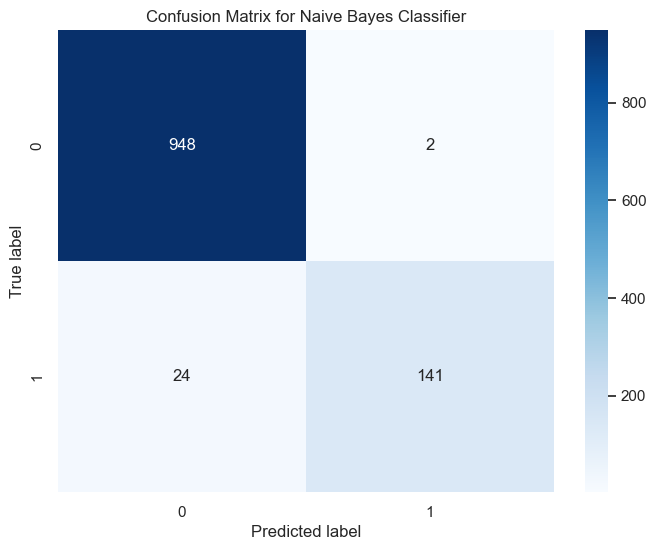

In [48]:
# Plotting using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_nb, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Naive Bayes Classifier')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

The Naive Bayes Classifier has been successfully trained and evaluated. Here are the results:

1. **Accuracy**: The model achieved an accuracy of approximately 97.7%.

2. **Classification Report**:
   - **Precision** measures the accuracy of positive predictions. For non-spam (0), it's 98%, and for spam (1), it's 99%.
   - **Recall** indicates how many of the actual positive cases were captured. For non-spam, the recall is 100%, and for spam, it's 85%.
   - **F1-Score** is a weighted average of Precision and Recall. For non-spam, the F1-score is 99%, and for spam, it's 92%.

3. **Confusion Matrix**:
   - The model correctly classified 948 non-spam and 141 spam messages.
   - There were 2 false positives (non-spam messages incorrectly classified as spam) and 24 false negatives (spam messages incorrectly classified as non-spam).

Overall, the Naive Bayes Classifier performed quite well, especially in identifying non-spam messages. The slight challenge is in identifying spam messages, as indicated by the lower recall for spam.

### b. Logistic Regression

In [31]:
# Training the Logistic Regression model
logistic_regression_model = LogisticRegression()
logistic_regression_model.fit(X_train, y_train)

LogisticRegression()

In [32]:
# Predicting the Test set results
y_pred_lr = logistic_regression_model.predict(X_test)

In [33]:
# Evaluating the model
accuracy_lr = accuracy_score(y_test, y_pred_lr)
report_lr = classification_report(y_test, y_pred_lr)
confusion_matrix_lr = confusion_matrix(y_test, y_pred_lr)

In [34]:

accuracy_lr

0.967713004484305

In [35]:
print(report_lr)

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       950
           1       0.98      0.79      0.88       165

    accuracy                           0.97      1115
   macro avg       0.98      0.90      0.93      1115
weighted avg       0.97      0.97      0.97      1115



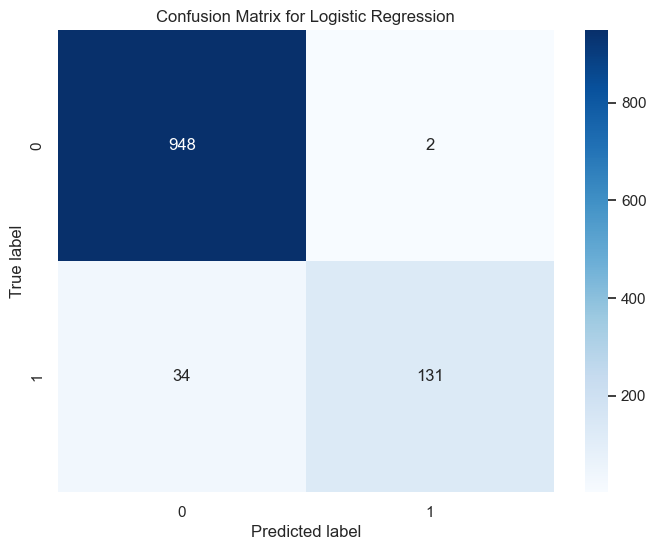

In [49]:
# Plotting using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_lr, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Logistic Regression')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

The Logistic Regression model has been trained and evaluated. Here are the results:

1. **Accuracy**: The model achieved an accuracy of approximately 96.8%.

2. **Classification Report**:
   - **Precision**: For non-spam (0), it's 97%, and for spam (1), it's 98%.
   - **Recall**: For non-spam, the recall is 100%, and for spam, it's 79%.
   - **F1-Score**: For non-spam, the F1-score is 98%, and for spam, it's 88%.

3. **Confusion Matrix**:
   - The model correctly classified 948 non-spam and 131 spam messages.
   - There were 2 false positives and 34 false negatives.

The Logistic Regression model shows a strong performance, particularly in classifying non-spam messages. However, similar to the Naive Bayes Classifier, it faces some challenges in accurately identifying spam messages, as evidenced by the lower recall and F1-score for spam.

### c. Neural Network

#### Implementing a Simple Feedforward Neural Network using Keras:

1. **Define the Neural Network Structure**:
   - Use a `Sequential` model.
   - Add a `Dense` layer with 64 neurons and ReLU activation. This will be your input layer.
   - Add a `Dropout` layer with a rate of 0.5 to prevent overfitting.
   - Add another `Dense` layer with 32 neurons and ReLU activation.
   - Add another `Dropout` layer with a rate of 0.5.
   - Finally, add a `Dense` output layer with 1 neuron and a sigmoid activation function for binary classification.

2. **Compile the Model**:
   - Use the Adam optimizer.
   - Set the loss function to `binary_crossentropy` as it's a binary classification problem.
   - Track the accuracy metric.

3. **Train the Model**:
   - Fit the model on the training data (`X_train`, `y_train`).
   - Set a reasonable number of epochs (e.g., 10).
   - Use a batch size of 128.
   - Include validation data (`X_test`, `y_test`) for monitoring the performance.

4. **Evaluate the Model**:
   - After training, evaluate the model's performance on the test set.
   - Monitor metrics like accuracy, and if needed, precision and recall.

In [38]:
# Defining the neural network structure
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

In [39]:
# Compiling the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [40]:
# Training the model
history = model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test), verbose=2)

Epoch 1/10


35/35 - 2s - loss: 0.6247 - accuracy: 0.8127 - val_loss: 0.5234 - val_accuracy: 0.8520 - 2s/epoch - 64ms/step
Epoch 2/10
35/35 - 0s - loss: 0.3931 - accuracy: 0.8695 - val_loss: 0.2896 - val_accuracy: 0.8520 - 209ms/epoch - 6ms/step
Epoch 3/10
35/35 - 0s - loss: 0.2350 - accuracy: 0.8755 - val_loss: 0.1996 - val_accuracy: 0.8762 - 188ms/epoch - 5ms/step
Epoch 4/10
35/35 - 0s - loss: 0.1605 - accuracy: 0.9325 - val_loss: 0.1390 - val_accuracy: 0.9614 - 197ms/epoch - 6ms/step
Epoch 5/10
35/35 - 0s - loss: 0.1022 - accuracy: 0.9778 - val_loss: 0.0946 - val_accuracy: 0.9767 - 192ms/epoch - 5ms/step
Epoch 6/10
35/35 - 0s - loss: 0.0678 - accuracy: 0.9843 - val_loss: 0.0759 - val_accuracy: 0.9794 - 196ms/epoch - 6ms/step
Epoch 7/10
35/35 - 0s - loss: 0.0514 - accuracy: 0.9886 - val_loss: 0.0709 - val_accuracy: 0.9812 - 207ms/epoch - 6ms/step
Epoch 8/10
35/35 - 0s - loss: 0.0425 - accuracy: 0.9901 - val_loss: 0.0701 - val_accuracy: 0.9812 - 187ms/epoch - 5ms/step
Epoch 9/10
35/35

In [41]:
# Evaluating the model
_, accuracy_nn = model.evaluate(X_test, y_test, verbose=0)

In [42]:
accuracy_nn

0.9820627570152283

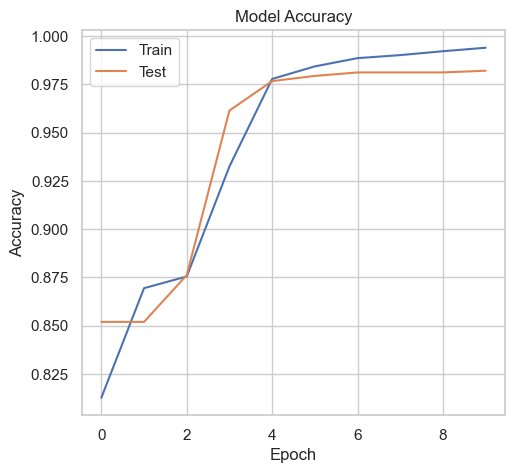

In [44]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

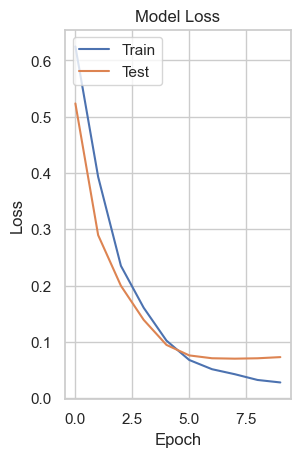

In [45]:
# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [46]:
# Predicting the Test set results
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

35/35 [==============================] - 0s 1ms/step


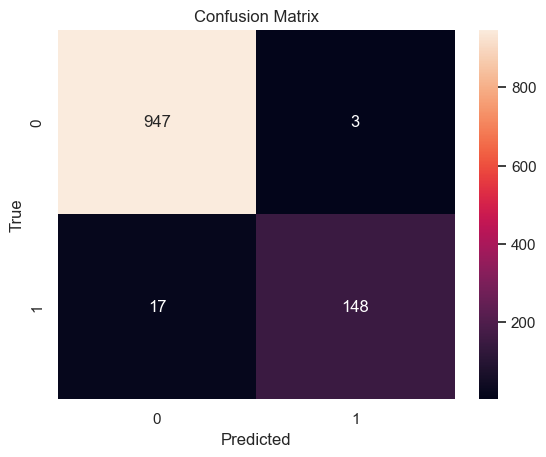

In [47]:
# Making the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Best Model

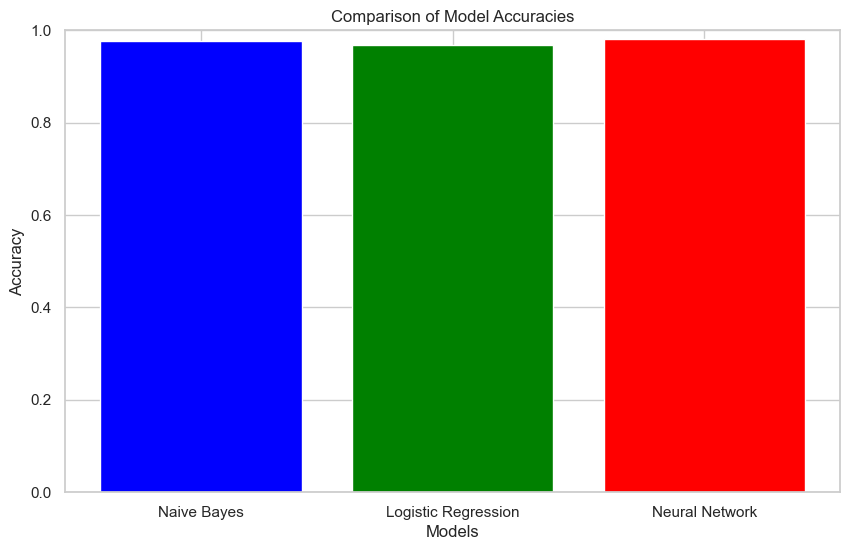

In [53]:
# Accuracies of the three models
accuracies = {
    'Naive Bayes': accuracy_nb,
    'Logistic Regression': accuracy_lr,
    'Neural Network': accuracy_nn
}

# Creating bar plot
plt.figure(figsize=(10, 6))
plt.bar(accuracies.keys(), accuracies.values(), color=['blue', 'green', 'red'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies')
plt.ylim([0, 1])
plt.show()

In [51]:
# Finding the model with the highest accuracy
best_model = max(accuracies, key=accuracies.get)
best_accuracy = accuracies[best_model]

print(f"The best model is {best_model} with an accuracy of {best_accuracy:.4f}")

The best model is Neural Network with an accuracy of 0.9821


## 5. Model Testing

In [54]:
# Let's use the model with the highest accuracy for prediction.

# Sample messages for prediction
sample_messages = [
    "Win a brand new car! Call now and claim your prize.",
    "Hey, are we still meeting for lunch tomorrow?",
    "Don't miss our exclusive sale! Discounts up to 70% off.",
    "This is a reminder for your dentist appointment on Thursday.",
    "Urgent! You have won a free vacation. Click the link to claim now."
]

In [55]:
# Pre-processing these sample messages
clean_sample_messages = [clean_text(msg) for msg in sample_messages]
sample_features = tfidf_converter.transform(clean_sample_messages).toarray()

In [56]:
# Predicting using the Neural Network
sample_predictions = model.predict(sample_features)
sample_predictions

1/1 [==============================] - 0s 39ms/step


array([[9.8198617e-01],
       [6.8088055e-05],
       [2.9254560e-03],
       [2.1153751e-03],
       [9.9329507e-01]], dtype=float32)

These values represent the model's confidence in classifying each message as spam (closer to 1) or not spam (closer to 0). Let's interpret the results:

1. For the message "Win a brand new car! Call now and claim your prize." - The output is approximately 0.982, which indicates a high confidence that this message is spam.
2. For "Hey, are we still meeting for lunch tomorrow?" - The output is approximately 0.00007, indicating a high confidence that this message is not spam.
3. For "Don't miss our exclusive sale! Discounts up to 70% off." - The output is approximately 0.0029, suggesting it is likely not spam.
4. For "This is a reminder for your dentist appointment on Thursday." - The output is approximately 0.0021, suggesting it is likely not spam.
5. For "Urgent! You have won a free vacation. Click the link to claim now." - The output is approximately 0.993, indicating a high confidence that this message is spam.

These results align well with what we might expect based on the content of the messages, with promotional and urgent-sounding messages being classified as spam, and more casual or informational messages being classified as not spam. This suggests that your neural network model is performing effectively in distinguishing spam from non-spam messages.